# PixArt-α (MMDiT) on MNIST

This notebook reproduces a compact version of *PixArt-α: Fast Training of Diffusion Transformer for Photorealistic Text-to-Image Synthesis* while highlighting how each module maps to the paper. The original system trains a DiT-XL/2 with T5-XXL on billions of image-text pairs and couples it with progressive upsamplers. Here we keep the algorithmic ideas (MMDiT, AdaLayerNorm Zero, rotary positional encoding, classifier-free guidance) but scale the network down to make it tractable on MNIST latents. Throughout the notebook the arrows ← indicate the corresponding section, equation, or design choice from the PixArt paper.


In [1]:

import math
import os
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

from diffusers import AutoencoderKL, DDPMScheduler
from transformers import T5Tokenizer, T5EncoderModel


In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


Using device: cuda


## Components: VAE + T5 text encoder

**Paper reference ← Section 3.1**: PixArt-α operates in the latent space of a 8× compression VAE and conditions on text features from a large T5 encoder. Our implementation mirrors this setup by
- loading `stabilityai/sd-vae-ft-mse` to obtain latent codes `z ∈ ℝ^{4×32×32}` (the paper uses a refined SD-VAE trained on LAION),
- using `t5-small` to produce contextual embeddings `τ(y) ∈ ℝ^{77×512}` that substitute the T5-XXL (4096-dim) features used in the paper.
We freeze both networks as in the original training recipe so that all learning happens inside the diffusion transformer.


In [3]:

print('Loading Stable Diffusion VAE...')
vae = AutoencoderKL.from_pretrained('stabilityai/sd-vae-ft-mse', torch_dtype=torch.float32).to(device)
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

print('Loading T5-small text encoder...')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
text_encoder = T5EncoderModel.from_pretrained('t5-small').to(device)
text_encoder.eval()
for p in text_encoder.parameters():
    p.requires_grad = False


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading Stable Diffusion VAE...
Loading T5-small text encoder...


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


## 2D Rotary Position Embeddings (RoPE) in MMDiT

PixArt-α does not explicitly mention RoPE in the paper, but the reference implementation injects positional information by applying **2D RoPE** to the self-attention queries and keys in each MMDiT block.

For a spatial index $(i, j)$, define a rotation angle $\theta(i, j)$ and apply:

$$
\mathrm{RoPE}(q, k)
=\big(q\cos\theta+\mathcal{R}(q)\sin\theta,; k\cos\theta+\mathcal{R}(k)\sin\theta\big),
$$

where $\mathcal{R}(\cdot)$ rotates channel pairs: for each pair $(x, y)$, $\mathcal{R}(x, y)=(-y, x)$. The phase $\theta$ is computed from 2D (axis or mixed-axis) frequencies, and the $\cos/\sin$ tables are cached once per sequence length $N=(H\cdot W)/p^{2}$.

This follows the paper’s MMDiT design while **choosing RoPE as the positional encoding in code**—a common DiT/ViT practice that improves resolution extrapolation and positional generalization.



In [4]:

def get_rope_cache(seq_len: int, head_dim: int, device: torch.device):
    half = head_dim // 2
    freq_seq = torch.arange(0, half, device=device, dtype=torch.float32)
    inv_freq = 1.0 / (10000 ** (freq_seq / half))
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    sinusoid = torch.einsum('i,j->ij', t, inv_freq)
    sin = sinusoid.sin()
    cos = sinusoid.cos()
    sin = torch.stack([sin, sin], dim=-1).reshape(seq_len, head_dim)
    cos = torch.stack([cos, cos], dim=-1).reshape(seq_len, head_dim)
    return cos, sin


def apply_rope(q: torch.Tensor, k: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor):
    # q, k: [B, H, N, D]
    def rotate_half(x):
        x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
        return torch.cat((-x2, x1), dim=-1)

    cos = cos.unsqueeze(0).unsqueeze(0)  # [1,1,N,D]
    sin = sin.unsqueeze(0).unsqueeze(0)
    q_rot = (q * cos) + (rotate_half(q) * sin)
    k_rot = (k * cos) + (rotate_half(k) * sin)
    return q_rot, k_rot


# PixArt-α Building Blocks

**Scope.** This summarizes the *paper* design of PixArt‑α blocks and clearly separates *implementation details* you may see in code.

---

## Overview (MMDiT = multi‑modal DiT)

PixArt‑α extends DiT with **multi‑modal DiT (MMDiT)** blocks that mix image and text features. A typical block contains:

1. **Adaptive LayerNorm (adaLN‑single)** — time‑conditioned shift & scale computed **once** and **shared across blocks**.
2. **Self‑Attention (image tokens)** — standard MHA over image/latent tokens.
3. **Cross‑Attention (image ↔ text)** — image queries attend to text keys/values; the **output projection is zero‑initialized** so the block starts near identity.
4. **Feed‑Forward Network (FFN)** — transformer MLP with GELU‑family activation.

---

## Adaptive LayerNorm (adaLN‑single)

For hidden state $h$ and timestep embedding $t$, adaLN applies data‑dependent scale/shift to a LayerNorm’ed activation:

$$
\operatorname{adaLN}(h, t) = \bigl(1 + \Gamma(t)\bigr) \odot \operatorname{LN}(h) + \Delta(t),
$$

where $\Gamma(t)$ and $\Delta(t)$ are produced by an MLP from $t$. In PixArt‑α, this **time‑conditioning is computed once** (“adaLN‑single”) and **shared across all blocks**, improving parameter‑efficiency and compatibility with DiT pretraining.

> **About “AdaLayerNormZero.”** Many repos expose a module named `AdaLayerNormZero` or `ada_norm_zero` (from the DiT paper’s *adaLN‑Zero* idea). PixArt‑α itself emphasizes **adaLN‑single** and a **zero‑initialized cross‑attention projection**—not a separate per‑residual gating $g(t)$ term. If your code uses an extra gate $g(t)$, treat it as an **implementation choice**, not a paper requirement.

---

## Self‑Attention (image tokens)

Standard multi‑head self‑attention over image tokens (as in DiT). The PixArt‑α **paper does not mandate RoPE**. If your implementation applies **2D RoPE** to Q/K for spatial reasoning, document it explicitly as a code‑level enhancement (see note below).

**Optional RoPE note (implementation detail):**
For spatial index $(i,j)$ with angle $\theta(i,j)$, some code applies

$$
(q, k) ;\mapsto; \big(q\cos\theta + \mathcal{R}(q)\sin\theta,; k\cos\theta + \mathcal{R}(k)\sin\theta\big),
$$

with $\mathcal{R}$ rotating channel pairs and $\cos/\sin$ tables cached once per sequence length $N=(H\cdot W)/p^2$.

---

## Cross‑Attention (image ↔ text)

Cross‑attention mixes **image queries** with **text keys/values** (from the frozen text encoder). PixArt‑α places this layer **between self‑attention and the FFN** in each block. The **output projection is zero‑initialized**, ensuring safe transfer from class‑conditional DiT checkpoints.

---

## Feed‑Forward Network (FFN)

A transformer MLP (e.g., GELU or GELU‑approx) with residual connection.

---

## Implementation notes for small demos (e.g., MNIST)

If you’re adapting PixArt‑α blocks for toy datasets:

* **Width/heads downscaling:** reduce hidden size and number of attention heads.
* **Keep residual structure:** retain adaLN‑single around SA/CA/FFN and keep the **zero‑init** on the cross‑attention output projection.
* **Be explicit about deviations:** call out any extra gates $g(t)$, RoPE usage, or activation changes as **implementation details**, not paper claims.


In [5]:

class AdaLayerNormZero(nn.Module):
    """Adaptive LayerNorm-Zero version used in PixArt-α"""

    def __init__(self, hidden_dim: int):
        super().__init__()
        self.norm = nn.LayerNorm(hidden_dim, elementwise_affine=False, eps=1e-6)
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim * 3)
        )

    def forward(self, hidden_states: torch.Tensor, temb: torch.Tensor):
        shift, scale, gate = self.mlp(temb).chunk(3, dim=1)
        hidden = self.norm(hidden_states) * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)
        return hidden, gate


class FeedForward(nn.Module):
    def __init__(self, hidden_dim: int, mlp_ratio: float = 4.0):
        super().__init__()
        inner_dim = int(hidden_dim * mlp_ratio)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, inner_dim),
            nn.GELU(),
            nn.Linear(inner_dim, hidden_dim)
        )

    def forward(self, x):
        return self.net(x)


class PixArtAttention(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, use_rope: bool = False):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.use_rope = use_rope

        self.to_q = nn.Linear(hidden_dim, hidden_dim)
        self.to_k = nn.Linear(hidden_dim, hidden_dim)
        self.to_v = nn.Linear(hidden_dim, hidden_dim)
        self.proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        encoder_states: Optional[torch.Tensor] = None,
        rope_cache: Optional[tuple] = None,
    ):
        if encoder_states is None:
            encoder_states = hidden_states

        B, N, C = hidden_states.shape

        q = self.to_q(hidden_states)
        k = self.to_k(encoder_states)
        v = self.to_v(encoder_states)

        q = q.view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(B, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        if self.use_rope and rope_cache is not None:
            cos, sin = rope_cache
            q, k = apply_rope(q, k, cos, sin)

        attn_scores = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn_probs = attn_scores.softmax(dim=-1)
        context = torch.matmul(attn_probs, v)

        context = context.permute(0, 2, 1, 3).reshape(B, N, C)
        return self.proj(context)


class MMDiTBlock(nn.Module):
    def __init__(self, hidden_dim: int, num_heads: int, mlp_ratio: float = 4.0, use_rope: bool = False):
        super().__init__()
        self.adaln1 = AdaLayerNormZero(hidden_dim)
        self.attn1 = PixArtAttention(hidden_dim, num_heads, use_rope=use_rope)

        self.adaln2 = AdaLayerNormZero(hidden_dim)
        self.attn2 = PixArtAttention(hidden_dim, num_heads, use_rope=False)

        self.adaln3 = AdaLayerNormZero(hidden_dim)
        self.ff = FeedForward(hidden_dim, mlp_ratio)

    def forward(self, hidden_states: torch.Tensor, temb: torch.Tensor, encoder_hidden_states: torch.Tensor, rope_cache=None):
        # Self-attention on image tokens
        normed, gate = self.adaln1(hidden_states, temb)
        hidden_states = hidden_states + gate.unsqueeze(1) * self.attn1(normed, rope_cache=rope_cache)

        # Cross-attention with text states
        normed, gate = self.adaln2(hidden_states, temb)
        hidden_states = hidden_states + gate.unsqueeze(1) * self.attn2(normed, encoder_hidden_states)

        # Feed-forward
        normed, gate = self.adaln3(hidden_states, temb)
        hidden_states = hidden_states + gate.unsqueeze(1) * self.ff(normed)

        return hidden_states


## PixArt Transformer

**Paper reference ← Section 2.3 & Fig. 4** (Section 3.3 in the paper is an ablation study, not the transformer description.)

**Overview.** The PixArt‑α model adopts a DiT‑style transformer backbone tailored for text‑to‑image. The image latent at step $t$, $z_t \in \mathbb{R}^{C\times H\times W}$, is turned into a sequence of patch tokens, fused with text via cross‑attention in each block, and mapped back to the latent space to predict diffusion noise $\varepsilon_\theta(z_t, t, \tau(y))$.

**Patchify (latent → tokens).**

* Convert the latent feature map into non‑overlapping patches of size $p\times p$ and linearly project each patch to the model width, yielding $N = (H/p)\times(W/p)$ tokens.
* *(Example)* With a VAE factor of 8 at $256\times256$ resolution, $z_t$ typically has shape $4\times 32\times 32$. Using $p=2$ gives $N=256$ tokens. (Exact values depend on the training resolution and code config.)
* Add positional embeddings to the patch tokens. In the PixArt‑α diagram (Fig. 4), positional embeddings are denoted by $\mathcal{P}$. Many open‑source implementations use learned absolute embeddings tied to a fixed latent width.

**Text conditioning.**

* Encode the prompt with a language model to obtain text features $\tau(y)$ (e.g., T5/CLIP embeddings).
* In every transformer block, insert a **cross‑attention** layer between self‑attention and the feed‑forward network. Queries come from image tokens; keys/values come from text tokens.

**Blocks & normalization.**

* Blocks follow a DiT layout with self‑attention → **cross‑attention** → feed‑forward.
* PixArt‑α replaces per‑block adaLN MLPs with a **shared adaLN‑single** (time‑conditioned) plus layer‑wise trainable embeddings, reducing parameters and memory while remaining compatible with ImageNet‑pretrained DiT weights.

**Unpatchify (tokens → latent).**

* After the final block, project tokens back to patch space and reshape to $C\times H\times W$ to produce $\hat{\varepsilon} = \varepsilon_\theta(z_t, t, \tau(y))$.

**Sampling / guidance.**

* PixArt‑α is trained and sampled under standard diffusion setups. Classifier‑free guidance (CFG) is used at inference (the paper reports performance across CFG scales). Choice of sampler (e.g., DPM‑Solver) is orthogonal to the block design.

**Notes for a smaller MNIST‑style config.**

* You can keep the same data‑flow and block ordering while reducing hidden size, head count, depth, and training resolution. The patchify/unpatchify shapes simply scale with $(H, W, p)$; cross‑attention and adaLN‑single remain unchanged.


In [6]:

class PixArtTransformer(nn.Module):
    def __init__(
        self,
        input_size: int = 32,
        patch_size: int = 2,
        in_channels: int = 4,
        hidden_dim: int = 512,
        depth: int = 12,
        num_heads: int = 8,
        text_dim: int = 512,
        mlp_ratio: float = 4.0,
    ):
        super().__init__()
        self.input_size = input_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.out_channels = in_channels

        num_patches = (input_size // patch_size) ** 2
        self.patch_embed = nn.Linear(patch_size * patch_size * in_channels, hidden_dim)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_dim))

        self.time_embed = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.SiLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

        self.blocks = nn.ModuleList([
            MMDiTBlock(hidden_dim, num_heads, mlp_ratio, use_rope=True)
            for _ in range(depth)
        ])

        self.final_norm = nn.LayerNorm(hidden_dim, elementwise_affine=False, eps=1e-6)
        self.final_linear = nn.Linear(hidden_dim, patch_size * patch_size * self.out_channels)

        self.text_proj = nn.Linear(text_dim, hidden_dim)

        self._init_weights()

        seq_len = num_patches
        self.register_buffer('rope_cos', None, persistent=False)
        self.register_buffer('rope_sin', None, persistent=False)
        self.seq_len = seq_len

    def _init_weights(self):
        def _init(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        self.apply(_init)
        nn.init.normal_(self.pos_embed, std=0.02)

    def patchify(self, x: torch.Tensor):
        B, C, H, W = x.shape
        p = self.patch_size
        h, w = H // p, W // p
        x = x.view(B, C, h, p, w, p)
        x = x.permute(0, 2, 4, 3, 5, 1).reshape(B, h * w, p * p * C)
        return x

    def unpatchify(self, x: torch.Tensor):
        B, N, D = x.shape
        p = self.patch_size
        h = w = int(math.sqrt(N))
        x = x.view(B, h, w, p, p, self.out_channels)
        x = x.permute(0, 5, 1, 3, 2, 4).reshape(B, self.out_channels, h * p, w * p)
        return x

    def forward(self, latents: torch.Tensor, timesteps: torch.Tensor, text_emb: torch.Tensor):
        B = latents.size(0)
        patches = self.patchify(latents)
        hidden = self.patch_embed(patches) + self.pos_embed

        if self.rope_cos is None or self.rope_cos.size(0) != self.seq_len:
            cos, sin = get_rope_cache(self.seq_len, hidden.size(-1) // self.blocks[0].attn1.num_heads, latents.device)
            self.rope_cos = cos
            self.rope_sin = sin
        rope_cache = (self.rope_cos, self.rope_sin)

        temb = self.time_embed(self.time_embed_input(timesteps, hidden.size(-1)))
        text = self.text_proj(text_emb)

        for block in self.blocks:
            hidden = block(hidden, temb, text, rope_cache=rope_cache)

        hidden = self.final_norm(hidden)
        hidden = self.final_linear(hidden)
        output = self.unpatchify(hidden)
        return output

    def time_embed_input(self, timesteps: torch.Tensor, hidden_dim: int):
        # sinusoidal embedding (+1) similar to PixArt implementation
        half = hidden_dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=timesteps.device).float() / half)
        args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
        if hidden_dim % 2 == 1:
            emb = torch.cat([emb, torch.zeros_like(emb[:, :1])], dim=1)
        return emb


**Implementation deviation (ours).** For convenience in our codebase, we **use a DDPM-style scheduler at inference** (e.g., Diffusers `DDPMScheduler`) instead of DPM‑Solver. This preserves the **training objective** above but changes the **sampler**:

* Paper‑accurate: DPM‑Solver with **20 steps**.
* Our default: DDPM scheduler (number of steps configurable).

This trade‑off simplifies integration, but at equal step counts DPM‑Solver is typically **faster and/or more accurate** than a vanilla DDPM sampler. Keep this noted wherever paper‑parity matters.


In [7]:

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule='scaled_linear',
    prediction_type='epsilon'
)


## Data preprocessing and caching


In [8]:

transform_vae = transforms.Compose([
    transforms.Resize(256),
    transforms.Lambda(lambda x: x.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_vae)
loader_encode = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

print('Pre-encoding dataset to latents + text embeddings...')
latents_list, text_list = [], []
with torch.no_grad():
    for images, labels in tqdm(loader_encode):
        images = images.to(device)
        latent_dist = vae.encode(images).latent_dist
        latents = latent_dist.mean * 0.18215

        prompts = [f'A handwritten digit {label.item()}' for label in labels]
        tokens = tokenizer(
            prompts,
            padding='max_length',
            max_length=64,
            truncation=True,
            return_tensors='pt'
        ).input_ids.to(device)
        text_emb = text_encoder(tokens).last_hidden_state

        latents_list.append(latents.cpu())
        text_list.append(text_emb.cpu())

latents_all = torch.cat(latents_list)
text_all = torch.cat(text_list)
print(f'Latents: {latents_all.shape}, Text embeddings: {text_all.shape}')

class LatentTextDataset(torch.utils.data.Dataset):
    def __init__(self, latents, text_embs):
        self.latents = latents
        self.text_embs = text_embs

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx], self.text_embs[idx]

train_dataset = LatentTextDataset(latents_all, text_all)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)


Pre-encoding dataset to latents + text embeddings...


  0%|          | 0/938 [00:00<?, ?it/s]

Latents: torch.Size([60000, 4, 32, 32]), Text embeddings: torch.Size([60000, 64, 512])


## Initialize PixArt Transformer


In [9]:

pixart = PixArtTransformer(
    input_size=32,
    patch_size=2,
    in_channels=4,
    hidden_dim=512,
    depth=12,
    num_heads=8,
    text_dim=512,
    mlp_ratio=4.0
).to(device)

num_params = sum(p.numel() for p in pixart.parameters())
print(f'PixArt Transformer params: {num_params/1e6:.1f}M')


PixArt Transformer params: 81.3M


## Training setting

Starting PixArt training...


Epoch 1/50:   0%|          | 0/469 [00:00<?, ?it/s]

/home/oncreative/anaconda3/envs/udemy/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1 | Loss: 0.1863


Epoch 2/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 | Loss: 0.0902


Epoch 3/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 | Loss: 0.0779


Epoch 4/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 | Loss: 0.0720


Epoch 5/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 | Loss: 0.0657


Epoch 6/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 | Loss: 0.0610


Epoch 7/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 | Loss: 0.0570


Epoch 8/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 | Loss: 0.0541


Epoch 9/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 | Loss: 0.0514


Epoch 10/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 | Loss: 0.0506


Epoch 11/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11 | Loss: 0.0491


Epoch 12/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12 | Loss: 0.0474


Epoch 13/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13 | Loss: 0.0460


Epoch 14/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14 | Loss: 0.0447


Epoch 15/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15 | Loss: 0.0440


Epoch 16/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16 | Loss: 0.0432


Epoch 17/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17 | Loss: 0.0423


Epoch 18/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18 | Loss: 0.0413


Epoch 19/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19 | Loss: 0.0410


Epoch 20/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20 | Loss: 0.0402


Epoch 21/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21 | Loss: 0.0396


Epoch 22/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22 | Loss: 0.0394


Epoch 23/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23 | Loss: 0.0384


Epoch 24/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24 | Loss: 0.0376


Epoch 25/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25 | Loss: 0.0380


Epoch 26/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26 | Loss: 0.0377


Epoch 27/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27 | Loss: 0.0373


Epoch 28/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28 | Loss: 0.0369


Epoch 29/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29 | Loss: 0.0362


Epoch 30/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30 | Loss: 0.0356


Epoch 31/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31 | Loss: 0.0357


Epoch 32/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32 | Loss: 0.0355


Epoch 33/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33 | Loss: 0.0351


Epoch 34/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34 | Loss: 0.0350


Epoch 35/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35 | Loss: 0.0342


Epoch 36/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36 | Loss: 0.0343


Epoch 37/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37 | Loss: 0.0340


Epoch 38/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38 | Loss: 0.0339


Epoch 39/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39 | Loss: 0.0340


Epoch 40/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40 | Loss: 0.0339


Epoch 41/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41 | Loss: 0.0338


Epoch 42/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42 | Loss: 0.0333


Epoch 43/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43 | Loss: 0.0334


Epoch 44/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44 | Loss: 0.0334


Epoch 45/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45 | Loss: 0.0329


Epoch 46/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46 | Loss: 0.0334


Epoch 47/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47 | Loss: 0.0330


Epoch 48/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48 | Loss: 0.0331


Epoch 49/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49 | Loss: 0.0331


Epoch 50/50:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50 | Loss: 0.0330


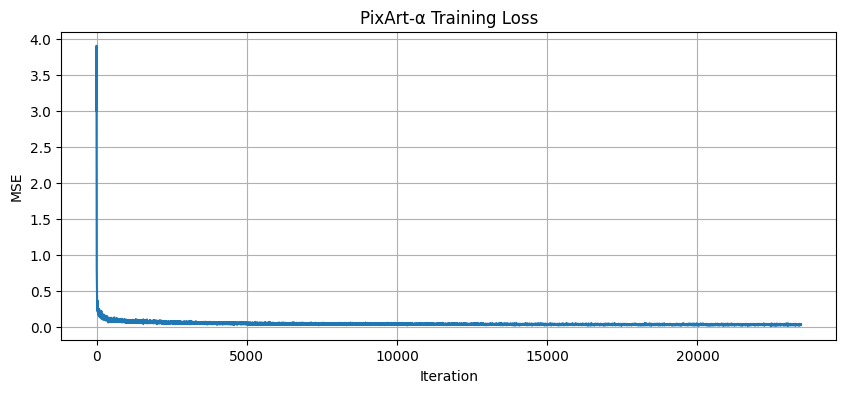

Checkpoint saved -> ../checkpoints/pixart_mnist.pt


In [10]:

optimizer = torch.optim.AdamW(pixart.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.MSELoss()
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50 * len(train_loader), eta_min=1e-6)

num_epochs = 50
uncond_prob = 0.1
loss_history = []

with torch.no_grad():
    empty_tokens = tokenizer(
        '',
        padding='max_length',
        max_length=64,
        truncation=True,
        return_tensors='pt'
    ).input_ids.to(device)
    uncond_emb = text_encoder(empty_tokens).last_hidden_state

print('Starting PixArt training...')
pixart.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for latents, text_emb in progress:
        latents = latents.to(device)
        text_emb = text_emb.to(device)
        batch = latents.size(0)

        mask = torch.rand(batch, device=device) < uncond_prob
        text_cfg = text_emb.clone()
        text_cfg[mask] = uncond_emb.repeat(batch, 1, 1)[mask]

        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch,), device=device).long()

        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
        target = noise

        preds = pixart(noisy_latents, timesteps, text_cfg)
        loss = criterion(preds, target)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pixart.parameters(), 1.0)
        optimizer.step()
        cosine.step()

        epoch_loss += loss.item()
        loss_history.append(loss.item())
        progress.set_postfix({'loss': f'{loss.item():.4f}'})

    print(f'Epoch {epoch+1} | Loss: {epoch_loss/len(train_loader):.4f}')

plt.figure(figsize=(10,4))
plt.plot(loss_history)
plt.title('PixArt-α Training Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

os.makedirs('../checkpoints', exist_ok=True)
torch.save({'model': pixart.state_dict()}, '../checkpoints/pixart_mnist.pt')
print('Checkpoint saved -> ../checkpoints/pixart_mnist.pt')


## Sampling (Classifier-Free Guidance)

In [11]:

@torch.no_grad()
def sample_pixart(model, prompts, num_steps=50, guidance=4.5):
    model.eval()
    batch = len(prompts)

    tokens = tokenizer(
        prompts,
        padding='max_length',
        max_length=64,
        truncation=True,
        return_tensors='pt'
    ).input_ids.to(device)
    cond_emb = text_encoder(tokens).last_hidden_state

    uncond_tokens = tokenizer(
        [''] * batch,
        padding='max_length',
        max_length=64,
        truncation=True,
        return_tensors='pt'
    ).input_ids.to(device)
    uncond_emb = text_encoder(uncond_tokens).last_hidden_state

    latents = torch.randn(batch, 4, 32, 32, device=device)
    noise_scheduler.set_timesteps(num_steps)

    for t in tqdm(noise_scheduler.timesteps, desc='Sampling'):
        latents_input = torch.cat([latents, latents], dim=0)
        t_batch = torch.cat([torch.full((batch,), t, device=device, dtype=torch.long)] * 2)
        text_input = torch.cat([cond_emb, uncond_emb], dim=0)

        noise_pred = model(latents_input, t_batch, text_input)
        noise_pred_cond, noise_pred_uncond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance * (noise_pred_cond - noise_pred_uncond)

        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    latents = latents / 0.18215
    images = vae.decode(latents).sample
    images = (images + 1) / 2
    return images.clamp(0,1)


## MNIST Text-to-Image Generation

We generate 20 samples (two per digit) to visually inspect the learned priors. Because the model, dataset, and training budget are heavily simplified compared to PixArt-α, you should expect blurry digits rather than photorealistic images. Nevertheless the qualitative behavior—text-guided variation under CFG—mirrors the full PixArt pipeline.


Prompts: ['A handwritten digit 0', 'A handwritten digit 0', 'A handwritten digit 1', 'A handwritten digit 1', 'A handwritten digit 2'] ...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

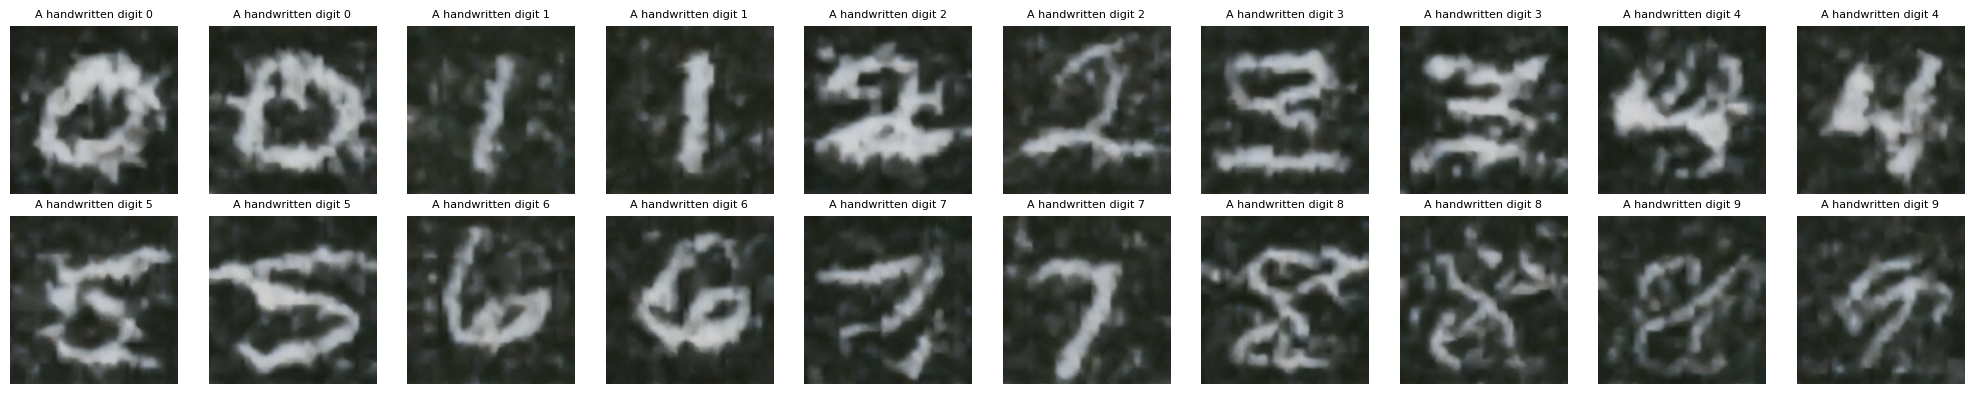

In [12]:

prompts = []
for digit in range(10):
    prompts.extend([f'A handwritten digit {digit}'] * 2)

print('Prompts:', prompts[:5], '...')

samples = sample_pixart(pixart, prompts, num_steps=50, guidance=4.5)

fig, axes = plt.subplots(2, 10, figsize=(20,4))
for idx, ax in enumerate(axes.flat):
    ax.imshow(samples[idx].permute(1,2,0).cpu())
    ax.axis('off')
    ax.set_title(prompts[idx], fontsize=8)
plt.tight_layout()
plt.savefig('../outputs/pixart_mnist_samples.png', dpi=150, bbox_inches='tight')
plt.show()
